# Sobol Option Pricing

In this notebook, we demonstate how to use the C++ sobol random number generator in the process of pricing call options.

We compare a number of methods for pricing both **Asian** and **European** call options, using both **Black Scholes** and **Monte Carlo** techniques. Within the Monte Carlo method, option prices are generated using the following combinations of methods:
- **Random** number generation with **Standard** approximation.
- **Sobol** number generation with **Standard** approximation.
- **Sobol** number generation with **Brownian Bridge** approximation.

The Black Scholes functions for each market produces a closed form solution with a deterministic result, while the Monte Carlo functions perform a number of random experiments and return an average price, based on the option type and the strike price.

In the final example below, the **RMSE** is calculated between the Monte Carlo and Black Scholes prices. The process is repeated for an increasing number of paths, with resulting errors compared.

---

### Requirements

The functions used throughout this notebook require the following packages to be installed:
- [FFI](https://github.com/kxsystems/ffi)
- Sobol executable - placed in `$QHOME/l64`
- matplotlib

---

### Load q scripts

We start by loading q scripts which contain wrappers for the C++ random and sobol sequence number generators, along with the functions required to produce both cumulative and inverse cumulative normal distibutions.

Graphics functions used throughout this notebook have also been loaded in.

In [1]:
\c 20 70
\l norm.q
\l rand.q
\l graphics/graphics.q

---

## Black Scholes Option Pricing

One method used to calulcate option prices is the Black Scholes formula, derived from the [Black Scholes equation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation). In this notebook, we look at the Black Scholes methods for both Asian and European call options. The function for each market produces a closed form solution with a deterministic result.

For European call options, the price of the corresponding option at time t, $P(S_{t},t)$, is given by:

$$\begin{eqnarray}
d_{1} = \frac{1}{\sigma\sqrt{T-t}}\Big[ln\Big(\frac{S_{t}}{K}\Big)+\Big((r-q)+\frac{\sigma^{2}}{2}\Big)(T-t)\Big]
\end{eqnarray}$$

$$\begin{eqnarray}
d_{2} = d_{1}-\sigma\sqrt{T-t}
\end{eqnarray}$$

$$\begin{eqnarray}
P(S_{t},t) = S_{t}e^{-q(T-t)}N(d_{1})-Ke^{-r(T-t)}N(d_{2})
\end{eqnarray}$$

where the price is discounted by the dividends, $q$, throughout. [[1](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)]

For Asian call options, we implement the same fomula, using an adjusted $S_{t}$ and $\sigma^{2}$:

$$\begin{eqnarray}
\mu_{adj} = \frac{1}{2}\Big(r-\frac{\sigma}{2}\Big)\Big(1+\frac{1}{n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
\sigma^{2}_{adj} = \frac{\sigma^2}{3}\Big(1+\frac{1}{n}\Big)\Big(1+\frac{1}{2n}\Big)
\end{eqnarray}$$

$$\begin{eqnarray}
{S_{t}}_{adj} = S_{t}e^{\frac{1}{2}\sigma^{2}_{adj}(T-t)+\mu_{adj}-r}
\end{eqnarray}$$

The Black Scholes function for each option type are written below in q.

In [2]:
/ Black Scholes - European
bsEuroCall:{[pd]
 d1:(log[pd[`s]%pd`k]+t*(pd[`r]-pd`q)+.5*v*v)%vrtt:(v:pd`v)*sqrt t:pd`t;
 (pd[`s]*exp[neg t*pd`q]*cnorm1 d1)-pd[`k]*exp[neg t*pd`r]*cnorm1 d1-vrtt}

/ Black Scholes - Asian
bsAsiaCall:{[n;pd]
 adjmu:.5*((r:pd`r)-.5*v2:v*v:pd`v)*n1:1+1.%n;
 adjv2:(v2%3)*n1*1+.5%n;
 adjS :pd[`s]*exp(t:pd`t)*(hv2:.5*adjv2)+adjmu-r;
 d1:(log[adjS%k:pd`k]+t*(r-q:pd`q)+hv2)%rtv2:sqrt adjv2*t;
 (adjS*exp[neg q*t]*cnorm1 d1)-k*exp[neg r*t]*cnorm1 d1-rtv2}

We can see the output of both functions below, run for 500 timesteps. The required parameters for the functions must be specified in a dictionary prior to use and are as follows:
- `s` - Asset price at t=0
- `k` - Strike
- `v` - Volatility
- `r` - Interest rate
- `q` - Dividends
- `t` - Expiry

In [3]:
nsteps:500
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1
-1"European Black Scholes Price: ",string bseuro:bsEuroCall pd;
-1"Asian Black Scholes Price: ",string bsasia:bsAsiaCall[nsteps]pd;

European Black Scholes Price: 10.45058
Asian Black Scholes Price: 5.55623


---

## Monte Carlo Experiments

In order to generate option prices using Monte Carlo methods, a number of experiments must be performed. In each experiment, we:
1. Randomly generate a number n, `nSteps`, of numbers (random or sobol).
2. Convert into a normal distibution using `invcnorm`.
3. Convert into a Wiener path random walk using standard or Brownian bridge approximation.
4. Convert into an asset price path based on parameters `s`, `v`, `r`, `q` and `t`.
5. Convert into an option price based on the option type and strike price, `k`.

The prices produced are then averaged to get a final predicted price.

Below we demostrate the above process for a sobol sequences paired with the Brownian bridge approximation.

### 1. Random number generation

In the example below, 500 random numbers are generated for both random and sobol sequences, with results plotted for comparison.

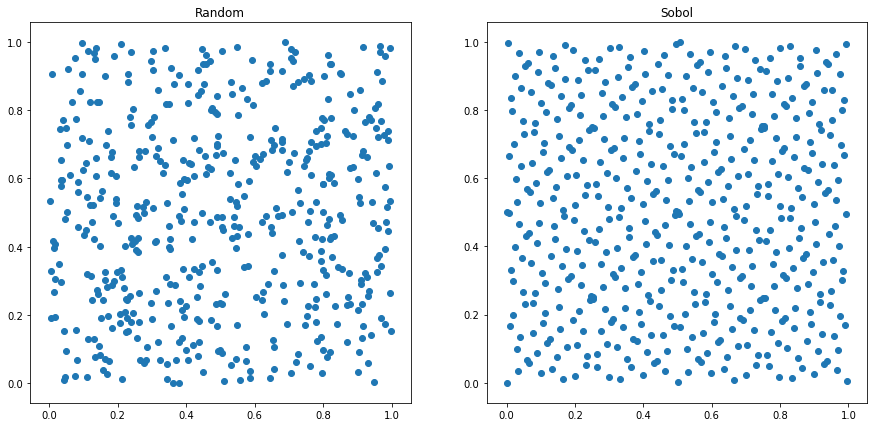

In [4]:
\S 20
rdm:(2;nsteps)#mtrand3 2*nsteps
sob:flip sobolrand each nsteps#2
subplot[rdm;sob;"Random";"Sobol"]

We see that the uniform random numbers do not actually look "random". Points tend to cluster together in some sections, while leaving large portions of white space in others. 

However, in the sobol example we see that points are better spaced out, with few points clumping together. This seems like a more realistic representation of a truly random sequence of numbers.

### 2. Convert to a Gaussian Distribution

The generated sequences are then converted from a uniform to a gaussian distribution. This means that values now around 68% of the values lie within one standard deviation, while two standard deviations account for around 95% and three account for 99.7%. [[1](https://en.wikipedia.org/wiki/Normal_distribution)]

<img src="graphics/gaussian.png" style="height:400px">

<u><b><center>Gaussian Distribution</center></b></u>

Below we demonstate how to convert the normal distibution for the generated sobol sequence to a normal distribution using the inverse cumulative normal function, `invcnorm`.

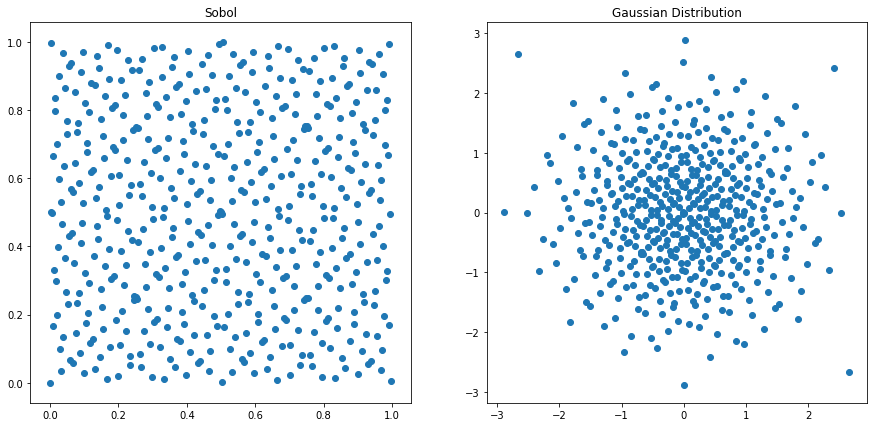

In [5]:
zsob:invcnorm each sob
subplot[sob;zsob;"Sobol";"Gaussian Distribution"]

The plots show that the distribution has changed to mirror that of the diagram above, with around 95% of the data sitting within 95% of the centre.

### 3. Convert into a Wiener path random walk

The next step in the Monte Carlo method is to create a random walk with discrete values and n steps (equal to the number of timesteps). In the standard approximation, this can be found by taking the cumulative sum across each value in the gaussian distribution.

For the Brownian bridge approximation, we first need to find the order of steps. This can be done using the method depicted below.

<img src="graphics/bbconstruct.png">

<b><u><center>The construction of a Brownian bridge over 14 steps</center></u></b>
<i><center>Jäckel P. Monte Carlo Methods In Finance. Chichester: J. Wiley; 2002.</center></i>

In the example shown, we have a total of 15 timesteps (0-14). The Wiener path is built up as follows:
- 0 and 14 are chosen as the first indices in the path, where we assume that the value at index 0 is 0.
- The method then uses the same rule throughout: move from the current index to the next initialized index on the right and find the midpoint between it and the next again index on the right as the next step in the path.
- In the example, the midpoint between 0 and 14 is 7 and so it is added as the next step in the Wiener path.
- We then move to the right, to 14, and as it does not have a right index, we move to 0.
- The next step is then to find half way between 0 and 7. Given that the true midpoint is 3.5, we round down and choose 3 as the next index.
- This process of moving to the right and finding the mid-point between indices is then repeated until there are no further indices left to add to the path.

The final path described above has the form: `14 7 3 10 1 5 8 12 2 4 6 9 11 13`

In [6]:
/ Build a Brownian bridge
bbridge:{[n;dt]
 bb:first flip(n-1).[i.initbb n]\(`bidx`ridx`lidx!3#n-1;((n-1)#0b),1b);
 bb:update lwt:bidx-lidx,rwt:ridx-bidx,sigma:ridx-lidx from bb;
 bb:update lwt%sigma,rwt%sigma,sigma:sqrt dt*lwt*rwt%sigma from bb;
 i.buildpath .[bb;(0;`sigma);:;sqrt n*dt]}

/ Create an initial Brownian bridge
i.initbb:{[n;d;m]
 if[n<=j:1+d`ridx;j:0];
 d:`bidx`ridx`lidx!(l:j+(k-j+1)div 2;k:j+first where j _m;-1+j+:first where not j _m);
 (d;@[m;l;:;1b])}

/ Create a path to follow
i.buildpath:{[bb;z]if[count[z]<>n:count bb;'`length];
 {[x;bb;z]@[x;bb`bidx;:;z+(x[bb`ridx]*bb`rwt)+$[0>l:bb`lidx;0;x[l]*bb`lwt]]
  }\[((n-1)#0.),first z*:bb`sigma;1_bb;1_z]}  / changed over to scan to should path building up

In [7]:
/ Recreating the above example
n:15
dt:1
last value bbex:bbridge[n;dt]

bidx ridx lidx lwt       rwt       sigma    
--------------------------------------------
14   14   14                       3.872983 
6    14   -1   0.4666667 0.5333333 1.932184 
2    6    -1   0.4285714 0.5714286 1.309307 
10   14   6    0.5       0.5       1.414214 
0    2    -1   0.3333333 0.6666667 0.8164966
4    6    2    0.5       0.5       1        
8    10   6    0.5       0.5       1        
12   14   10   0.5       0.5       1        
1    2    0    0.5       0.5       0.7071068
3    4    2    0.5       0.5       0.7071068
5    6    4    0.5       0.5       0.7071068
7    8    6    0.5       0.5       0.7071068
9    10   8    0.5       0.5       0.7071068
11   12   10   0.5       0.5       0.7071068
13   14   12   0.5       0.5       0.7071068


In [8]:
\c 20 110
u:sobolrand n
z:invcnorm u
bbex z

0         0        0         0         0         0         -2.713102 0         0         0         0       ..
0         0        -1.894846 0         0         0         -2.713102 0         0         0         0       ..
0         0        -1.894846 0         0         0         -2.713102 0         0         0         -2.22301..
0.6279974 0        -1.894846 0         0         0         -2.713102 0         0         0         -2.22301..
0.6279974 0        -1.894846 0         -2.820526 0         -2.713102 0         0         0         -2.22301..
0.6279974 0        -1.894846 0         -2.820526 0         -2.713102 0         -4.492072 0         -2.22301..
0.6279974 0        -1.894846 0         -2.820526 0         -2.713102 0         -4.492072 0         -2.22301..
0.6279974 1.257804 -1.894846 0         -2.820526 0         -2.713102 0         -4.492072 0         -2.22301..
0.6279974 1.257804 -1.894846 -1.027915 -2.820526 0         -2.713102 0         -4.492072 0         -2.22301..
0.6279974 

### 4. Convert into asset price path

In [9]:
/ Create a path to follow
i.buildpath:{[bb;z]if[count[z]<>n:count bb;'`length];
 {[x;bb;z]@[x;bb`bidx;:;z+(x[bb`ridx]*bb`rwt)+$[0>l:bb`lidx;0;x[l]*bb`lwt]]
  }/[((n-1)#0.),first z*:bb`sigma;1_bb;1_z]}  / change back to over to run spath

/ Create Wiener path
wpath:{[n;d;bb]$[(::)~bb;sums;bb]invcnorm$[d`sobol;sobolrand;mtrand3]n}

/ Convert into asset price path
spath:{[n;d;pd]pd[`s]*exp(wpath[n;d;d`bb]*pd[`v]*sqrt dt)+(1+til n)*dr:(pd[`r]-pd[`q]+.5*v*v:pd`v)*dt:pd[`t]%n}

In [10]:
npaths:10
bb:bbridge[nsteps;dt]
show sp:spath[;`bb`sobol!(bb;1b);pd]each npaths#nsteps

99.70327 99.61439 99.07735 99.69772 100.454  100.6546 99.06416 99.07757 99.89278 100.3007 100.3108 99.61233..
101.286  101.7097 100.2619 99.15185 99.41367 99.9818  100.1364 100.5155 100.5499 100.7477 101.7039 100.0299..
99.43052 99.13169 99.51924 100.7167 100.8675 99.90517 101.3341 100.3939 102.042  102.3832 100.9298 101.7744..
100.4562 99.23982 98.4285  99.58322 98.38313 99.31814 98.8908  97.78885 96.63991 97.49987 97.68995 96.92152..
100.5753 102.0285 101.0261 101.3885 102.1756 101.164  101.2161 99.30751 101.3578 100.4283 101.3664 102.0543..
99.71959 100.5818 100.6952 99.52284 100.1429 99.1999  101.6471 101.9266 100.9023 102.2263 101.2164 103.3502..
100.994  99.99751 100.7724 100.9363 100.366  99.93941 99.3839  98.99931 99.73756 99.00556 98.72355 98.60304..
100.0913 99.911   100.7385 98.95116 100.4402 100.6437 100.134  101.4807 100.6262 100.573  100.4053 101.5444..
99.79262 99.81724 98.42951 97.18531 95.81392 96.12456 98.20875 97.3807  97.04932 95.67118 97.66634 97.3116 ..
99.94622 9

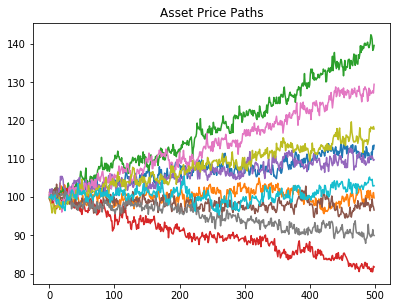

In [11]:
plt[`:title]"Asset Price Paths";
{plt[`:plot]x}each sp;
plt[`:show][];

### 5. Convert into option price

In [12]:
/ Monte Carlo prices for European call option
mcEuroCall:{[m;n;d;pd]exp[neg pd[`r]*pd`t]*avg 0|(last each spath[;d;pd]each m#n)-pd`k}

/ Monte Carlo prices for Asian call option
mcAsiaCall:{[m;n;d;pd]exp[neg pd[`r]*pd`t]*avg 0|(last each prds each xexp[;1%n]spath[;d;pd]each m#n)-pd`k}

In [13]:
-1"European Monte Carlo Price: ",string mcEuroCall[npaths;nsteps;`bb`sobol!(bb;1b);pd];
-1"Asian Monte Carlo Price: ",string mcAsiaCall[npaths;nsteps;`bb`sobol!(bb;1b);pd];

European Monte Carlo Price: 13.7281
Asian Monte Carlo Price: 3.92513


---

### Example

Here we pull everything together and compare the Black Scholes and Monte Carlo Methods, finding the relative RMSE.

First we need to create a dictionary of parameters, as shown previously.

In [14]:
pd:`s`k`v`r`q`t!100 100 .2 .05 0 1

We also need to initialize the number of paths (experiments), steps and trials.

In [15]:
l:20
m:8+64*til 16
n:1000

Given that the initial Brownian bridge will be the same throughout, it can also be initialized and passed in as an argument.

In [16]:
bb:bbridge[n;1]

We can now run the below functions which will calculate the RMSE between the Black Scholes and Monte Carlo prices for each market and each Monte Carlo technique.

In [ ]:
runall:{[l;n;pd;bb;m]
 out:"nPaths, bb/sobol std/sobol std/uniform errors, sobol/bb mc price";
 -1"Euro BS price ",string bseuro:bsEuroCall pd;-1 out;
 st:.z.p;run[bseuro;l;n;pd;bb;`european]each m;
 -1"Time taken = ",string .z.p-st;
 -1"\nAsia BS price ",string bsasia:bsAsiaCall[n;pd];-1 out;
 st:.z.p;run[bseuro;l;n;pd;bb;`asian]each m;
 -1"Time taken = ",string .z.p-st;}

run:{[bs;l;n;pd;bb;mkt;m]
 mc:$[mkt~`asian;mcAsiaCall;mcEuroCall];
 err_a:rmse[bs]a:mc[;n;`bb`sobol!(bb;1b);pd]each l#m;
 err_b:rmse[bs]b:mc[;n;`bb`sobol!(::;1b);pd]each l#m;
 err_c:rmse[bs]c:mc[;n;`bb`sobol!(bb;0b);pd]each l#m;
 -1", "sv string("f"$m;err_a;err_b;err_c;last a);}

rmse:{sqrt avg x*x-:y}

In [ ]:
/add table with npaths and errors, then plot all together to show convergence - could show with price too

In [ ]:
runall[l;n;pd;bb;m]